In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def solve_darcy_flow_with_constant_forcing(N, a_func, tol=1e-5, max_iter=2000):
    """
    Solve div(a(x, y) grad(u)) = f(x, y) with u = 0 on the boundary using a basic finite difference scheme.
    
    Parameters:
    - N: Number of grid points per dimension (excluding boundaries).
    - a_func: Function a(x, y), the coefficient of the equation.
    - f_func: Function f(x, y), the forcing term.
    - tol: Convergence tolerance for the iterative solver.
    - max_iter: Maximum number of iterations for the solver.
    
    Returns:
    - u: Solution array of shape (N+2, N+2), including boundaries.
    - a: Coefficient array of shape (N+2, N+2).
    - x, y: Grid points (including boundaries) for visualization.
    """
    # Grid setup
    L = 1.0  # Domain length
    h = L / (N + 1)  # Grid spacing
    x = np.linspace(0, L, N + 2)
    y = np.linspace(0, L, N + 2)
    X, Y = np.meshgrid(x, y, indexing="ij")
    
    # Coefficient a(x, y)
    a = a_func(X, Y)
    
    # constant forcing = 1
    f = 1
    
    # Initialize solution u with boundary conditions
    u = np.zeros((N + 2, N + 2))  # Including boundaries
    
    # Iterative solver: Jacobi method
    for k in range(max_iter):
        u_old = u.copy()
        
        # Update interior points using the finite difference scheme
        for i in range(1, N + 1):
            for j in range(1, N + 1):
                a_e = 0.5 * (a[i, j] + a[i + 1, j])  # Coefficient to the east
                a_w = 0.5 * (a[i, j] + a[i - 1, j])  # Coefficient to the west
                a_n = 0.5 * (a[i, j] + a[i, j + 1])  # Coefficient to the north
                a_s = 0.5 * (a[i, j] + a[i, j - 1])  # Coefficient to the south
                
                u[i, j] = (
                    a_e * u_old[i + 1, j]
                    + a_w * u_old[i - 1, j]
                    + a_n * u_old[i, j + 1]
                    + a_s * u_old[i, j - 1]
                    - h**2 * f
                ) / (a_e + a_w + a_n + a_s)
        
        # Convergence check
        diff = np.max(np.abs(u - u_old))
        if diff < tol:
            print(f"Converged in {k} iterations.")
            break
    else:
        print("Maximum iterations reached without convergence.")
    
    return u, a, x, y

# Example: Use sinusoidal variation
def a_func(X, Y):
    return 1 + np.sin(2 * np.pi * X) * np.sin(2 * np.pi * Y)


Converged in 1503 iterations.


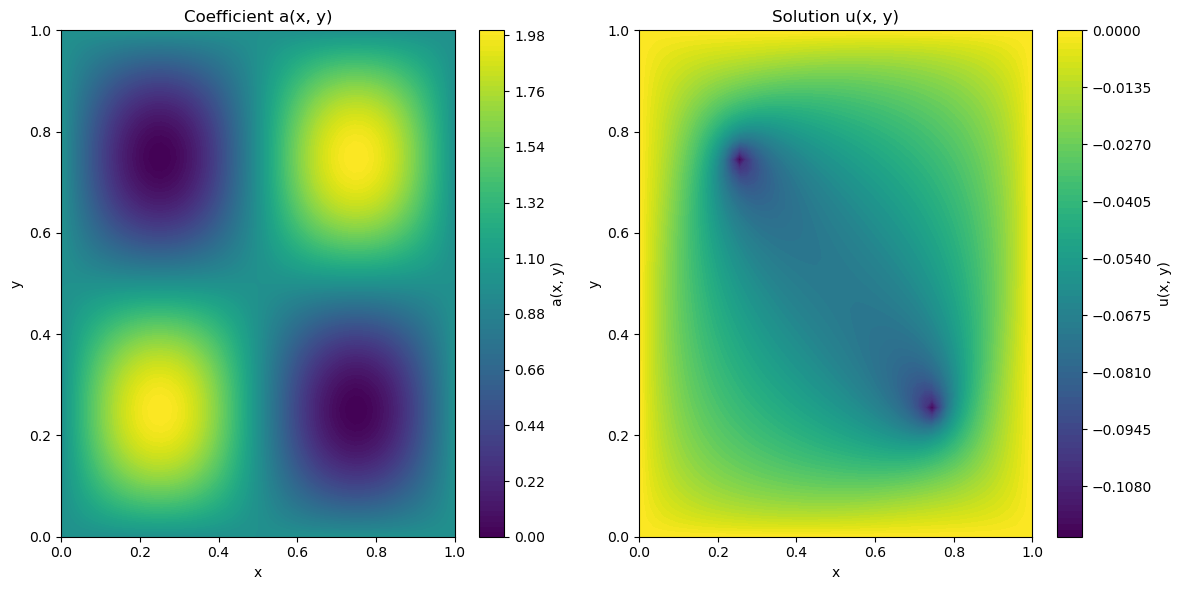

In [3]:
# Solve the PDE
N = 50  # Number of interior points per dimension
u, a, x, y = solve_darcy_flow_with_constant_forcing(N, a_func)

# Visualize a(x, y) and u(x, y) side by side
X, Y = np.meshgrid(x, y, indexing="ij")
plt.figure(figsize=(12, 6))

# Plot a(x, y)
plt.subplot(1, 2, 1)
plt.contourf(X, Y, a, levels=100, cmap="viridis")
plt.colorbar(label="a(x, y)")
plt.title("Coefficient a(x, y)")
plt.xlabel("x")
plt.ylabel("y")

# Plot u(x, y)
plt.subplot(1, 2, 2)
plt.contourf(X, Y, u, levels=100, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.title("Solution u(x, y)")
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()
plt.show()

# Set a(x,y) to be a gaussian field

$N(0, (-\Delta + 9I)^{-2})$ with push forward applied

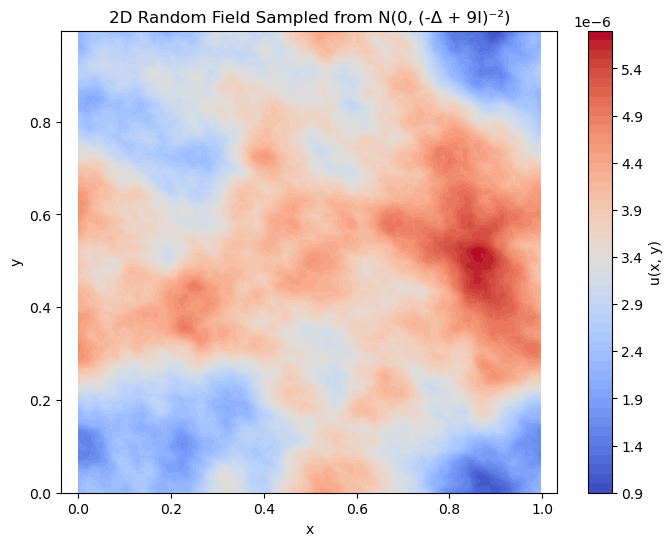

In [3]:
def generate_random_field_2D(Nx, Ny, Lx, Ly, scale=1, shift=9):
    """
    Generate a 2D random field sampled from N(0, scale * (-Delta + shift*I)^-2) on a periodic domain.

    Parameters:
        Nx, Ny (int): Number of grid points in x and y directions.
        Lx, Ly (float): Domain lengths in x and y directions.
        scale (float): Scaling factor for the covariance operator (default 625).
        shift (float): Shift parameter in the operator (default 25).

    Returns:
        x (ndarray): x-coordinates of the grid points.
        y (ndarray): y-coordinates of the grid points.
        field (ndarray): Sampled 2D random field.
    """
    # Define spatial grid
    x = np.linspace(0, Lx, Nx, endpoint=False)
    y = np.linspace(0, Ly, Ny, endpoint=False)
    kx = np.fft.fftfreq(Nx, d=Lx/Nx) * 2 * np.pi
    ky = np.fft.fftfreq(Ny, d=Ly/Ny) * 2 * np.pi
    KX, KY = np.meshgrid(kx, ky, indexing="ij")  # Wavenumber grid

    # Compute eigenvalues of the covariance operator
    eigenvalues = scale / ((KX**2 + KY**2) + shift)**2

    # Sample from Fourier coefficients
    random_coeffs = (np.random.normal(0, np.sqrt(eigenvalues)) +
                     1j * np.random.normal(0, np.sqrt(eigenvalues)))

    # Ensure reality of the field (complex conjugate symmetry)
    random_coeffs[Nx//2+1:, Ny//2+1:] = np.conj(random_coeffs[1:Nx//2, 1:Ny//2][::-1, ::-1])

    # Transform back to physical space
    field = np.fft.ifft2(random_coeffs).real
    
    return x, y, field

# Parameters
Nx, Ny = 256, 256  # Number of grid points in x and y directions
Lx, Ly = 1.0, 1.0  # Domain lengths in x and y directions

# Generate the 2D random field
x, y, field = generate_random_field_2D(Nx, Ny, Lx, Ly)

# Plot the result
X, Y = np.meshgrid(x, y, indexing="ij")
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, field, levels=50, cmap="coolwarm")
plt.colorbar(label="u(x, y)")
plt.title("2D Random Field Sampled from N(0, (-Δ + 9I)⁻²)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()


# Generate Gaussian Field and Solve 2D Darcy

In [4]:
def solve_darcy_flow_with_constant_forcing(N, tol=1e-5, max_iter=2000):
    """
    Solve div(a(x, y) grad(u)) = f(x, y) with u = 0 on the boundary using a basic finite difference scheme.
    
    Parameters:
    - N: Number of grid points per dimension (excluding boundaries).
    - a_func: Function a(x, y), the coefficient of the equation.
    - f_func: Function f(x, y), the forcing term.
    - tol: Convergence tolerance for the iterative solver.
    - max_iter: Maximum number of iterations for the solver.
    
    Returns:
    - u: Solution array of shape (N+2, N+2), including boundaries.
    - a: Coefficient array of shape (N+2, N+2).
    - x, y: Grid points (including boundaries) for visualization.
    """
    # Grid setup
    L = 1.0  # Domain length
    h = L / (N + 1)  # Grid spacing
    x = np.linspace(0, L, N + 2)
    y = np.linspace(0, L, N + 2)
    X, Y = np.meshgrid(x, y, indexing="ij")
    
    # Coefficient a(x, y)
    a = generate_random_field_2D(N+2, N+2, L, L)[2]
    
    # pushforward
    #a = abs(a)
    a = np.where(a < 0, 3, 12)


    
    # constant forcing = 1
    f = 1
    
    # Initialize solution u with boundary conditions
    u = np.zeros((N + 2, N + 2))  # Including boundaries
    
    # Iterative solver: Jacobi method
    for k in range(max_iter):
        u_old = u.copy()
        
        # Update interior points using the finite difference scheme
        for i in range(1, N + 1):
            for j in range(1, N + 1):
                a_e = 0.5 * (a[i, j] + a[i + 1, j])  # Coefficient to the east
                a_w = 0.5 * (a[i, j] + a[i - 1, j])  # Coefficient to the west
                a_n = 0.5 * (a[i, j] + a[i, j + 1])  # Coefficient to the north
                a_s = 0.5 * (a[i, j] + a[i, j - 1])  # Coefficient to the south
                
                u[i, j] = (
                    a_e * u_old[i + 1, j]
                    + a_w * u_old[i - 1, j]
                    + a_n * u_old[i, j + 1]
                    + a_s * u_old[i, j - 1]
                    - h**2 * f
                ) / (a_e + a_w + a_n + a_s)
        
        # Convergence check
        diff = np.max(np.abs(u - u_old))
        if diff < tol:
            print(f"Converged in {k} iterations.")
            break
    else:
        print("Maximum iterations reached without convergence.")
    
    return u, a, x, y

In [236]:
# Solve the PDE
N = 64  # Number of interior points per dimension
u, a, x, y = solve_darcy_flow_with_constant_forcing(N)

Converged in 599 iterations.


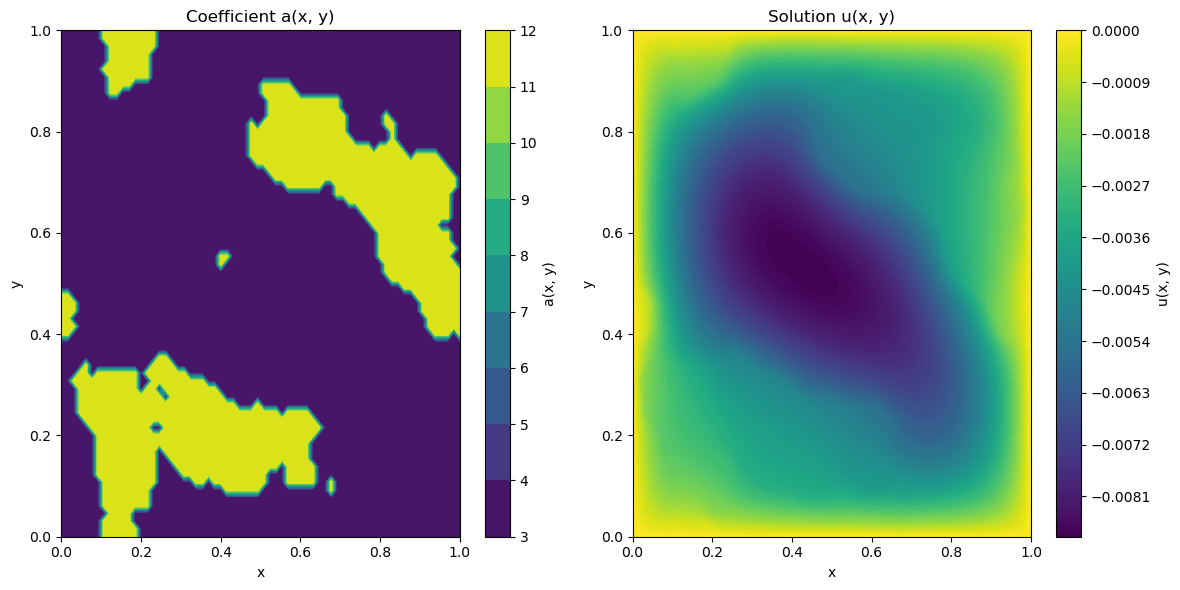

In [237]:
# Visualize a(x, y) and u(x, y) side by side
X, Y = np.meshgrid(x, y, indexing="ij")
plt.figure(figsize=(12, 6))

# Plot a(x, y)
plt.subplot(1, 2, 1)
plt.contourf(X, Y, a, levels=10, cmap="viridis")
plt.colorbar(label="a(x, y)")
plt.title("Coefficient a(x, y)")
plt.xlabel("x")
plt.ylabel("y")

# Plot u(x, y)
plt.subplot(1, 2, 2)
plt.contourf(X, Y, u, levels=100, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.title("Solution u(x, y)")
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()
plt.show()

# Arbitrary geometries

In [9]:
def solve_darcy_flow_with_general_geometries(N, mask_func=default_mask, tol=1e-5, max_iter=2000):
    """
    Solve div(a(x, y) grad(u)) = f(x, y) with u = 0 on the boundary using a basic finite difference scheme.
    
    Parameters:
    - N: Number of grid points per dimension (excluding boundaries).
    - a_func: Function a(x, y), the coefficient of the equation.
    - f_func: Function f(x, y), the forcing term.
    - tol: Convergence tolerance for the iterative solver.
    - max_iter: Maximum number of iterations for the solver.
    
    Returns:
    - u: Solution array of shape (N+2, N+2), including boundaries.
    - a: Coefficient array of shape (N+2, N+2).
    - x, y: Grid points (including boundaries) for visualization.
    """
    # Grid setup
    L = 1.0  # Domain length
    h = L / (N + 1)  # Grid spacing
    x = np.linspace(0, L, N + 2)
    y = np.linspace(0, L, N + 2)
    X, Y = np.meshgrid(x, y, indexing="ij")
    
    # Coefficient a(x, y)
    a = generate_random_field_2D(N+2, N+2, L, L)[2]
    
    # pushforward
    a = np.where(a > 0, 12, 3)
    
    # use mask func to do mask
    mask = mask_func(a)
    

    
    # set boundary conditions via mask
    a[mask==0] = 0

    
    # constant forcing = 1
    f = 1
    
    # Initialize solution u with boundary conditions
    u = np.zeros((N + 2, N + 2))  # Including boundaries
    
    # Iterative solver: Jacobi method
    for k in range(max_iter):
        u_old = u.copy()
        
        # Update interior points using the finite difference scheme
        for i in range(N+2):
            for j in range(N+2):
                if mask[i, j]:
                    a_e = 0.5 * (a[i, j] + a[i + 1, j])  # Coefficient to the east
                    a_w = 0.5 * (a[i, j] + a[i - 1, j])  # Coefficient to the west
                    a_n = 0.5 * (a[i, j] + a[i, j + 1])  # Coefficient to the north
                    a_s = 0.5 * (a[i, j] + a[i, j - 1])  # Coefficient to the south

                    u[i, j] = (
                        a_e * u_old[i + 1, j]
                        + a_w * u_old[i - 1, j]
                        + a_n * u_old[i, j + 1]
                        + a_s * u_old[i, j - 1]
                        - h**2 * f
                    ) / (a_e + a_w + a_n + a_s)
        
        # Convergence check
        diff = np.max(np.abs(u - u_old))
        if diff < tol:
            print(f"Converged in {k} iterations.")
            break
    else:
        print("Maximum iterations reached without convergence.")
    
    return u, a, x, y

In [10]:
def default_mask(a):
    
    mask = np.ones_like(a)
    
    mask[0, :] = 0
    mask[-1, :] = 0
    mask[:, 0] = 0
    mask[:, -1] = 0
                
    return mask

In [11]:
def donut_mask(a):
    
    mask = np.zeros_like(a)
    for i in range(N+2):
        for j in range(N+2):
            if (i-N//2)**2 + (j-N//2)**2 < (N/2.2)**2:
                mask[i,j] = 1

            if (i-N//2)**2 + (j-N//2)**2 < (N/6)**2:
                mask[i,j] = 0
                
    return mask

In [12]:
# Solve the PDE
N = 64  # Number of interior points per dimension
u, a, x, y = solve_darcy_flow_with_general_geometries(N)

Converged in 10 iterations.


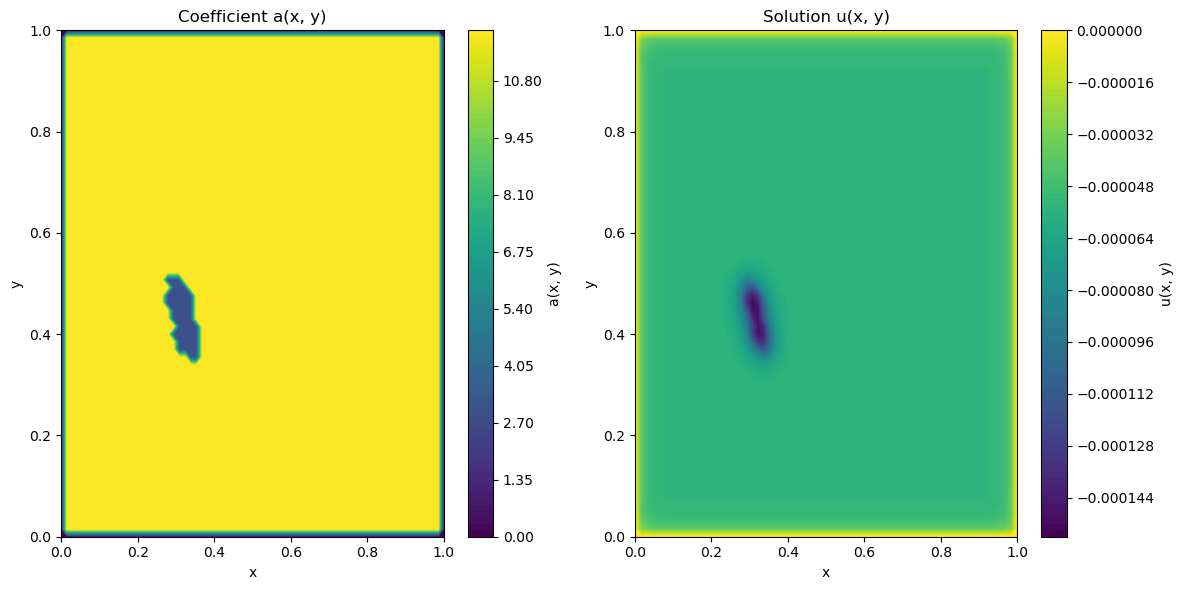

In [13]:
# Visualize a(x, y) and u(x, y) side by side
X, Y = np.meshgrid(x, y, indexing="ij")
plt.figure(figsize=(12, 6))

# Plot a(x, y)
plt.subplot(1, 2, 1)
plt.contourf(X, Y, a, levels=100, cmap="viridis")
plt.colorbar(label="a(x, y)")
plt.title("Coefficient a(x, y)")
plt.xlabel("x")
plt.ylabel("y")

# Plot u(x, y)
plt.subplot(1, 2, 2)
plt.contourf(X, Y, u, levels=100, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.title("Solution u(x, y)")
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()
plt.show()

In [14]:
# Solve the PDE
N = 64  # Number of interior points per dimension
u, a, x, y = solve_darcy_flow_with_general_geometries(N, mask_func=donut_mask)

Converged in 166 iterations.


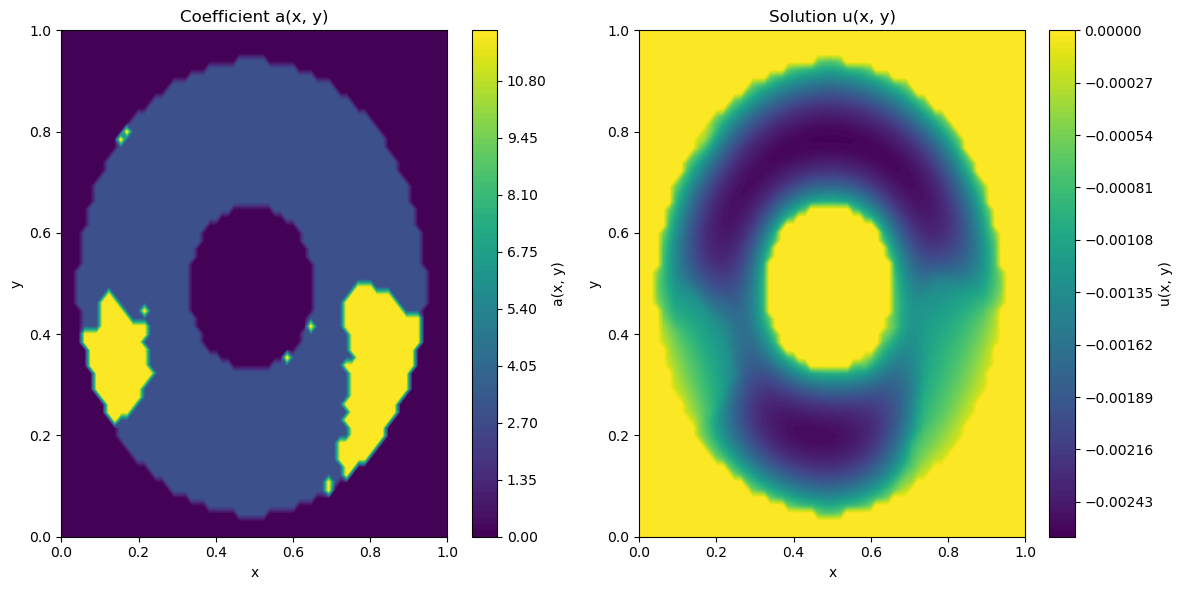

In [15]:
# Visualize a(x, y) and u(x, y) side by side
X, Y = np.meshgrid(x, y, indexing="ij")
plt.figure(figsize=(12, 6))

# Plot a(x, y)
plt.subplot(1, 2, 1)
plt.contourf(X, Y, a, levels=100, cmap="viridis")
plt.colorbar(label="a(x, y)")
plt.title("Coefficient a(x, y)")
plt.xlabel("x")
plt.ylabel("y")

# Plot u(x, y)
plt.subplot(1, 2, 2)
plt.contourf(X, Y, u, levels=100, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.title("Solution u(x, y)")
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()
plt.show()

# Generate the data

In [32]:
N_input_output_pairs = 1200 # 1000, 100, 100 train test validation split

input_output_pairs = []

for i in range(N_input_output_pairs):
    print(f"i = {i}")
    u, a, x, y = solve_darcy_flow_with_general_geometries(N, mask_func=donut_mask, tol=1e-6)
    input_output_pairs.append((a, u))

i = 0
Converged in 574 iterations.
i = 1
Converged in 573 iterations.
i = 2
Converged in 654 iterations.
i = 3
Converged in 465 iterations.
i = 4
Converged in 571 iterations.
i = 5
Converged in 591 iterations.
i = 6
Converged in 557 iterations.
i = 7
Converged in 748 iterations.
i = 8
Converged in 425 iterations.
i = 9
Converged in 608 iterations.
i = 10
Converged in 529 iterations.
i = 11
Converged in 549 iterations.
i = 12
Converged in 580 iterations.
i = 13
Converged in 619 iterations.
i = 14
Converged in 386 iterations.
i = 15
Converged in 659 iterations.
i = 16
Converged in 537 iterations.
i = 17
Converged in 580 iterations.
i = 18
Converged in 502 iterations.
i = 19
Converged in 385 iterations.
i = 20
Converged in 514 iterations.
i = 21
Converged in 535 iterations.
i = 22
Converged in 661 iterations.
i = 23
Converged in 554 iterations.
i = 24
Converged in 580 iterations.
i = 25
Converged in 531 iterations.
i = 26
Converged in 431 iterations.
i = 27
Converged in 538 iterations.
i 

Converged in 331 iterations.
i = 226
Converged in 331 iterations.
i = 227
Converged in 578 iterations.
i = 228
Converged in 686 iterations.
i = 229
Converged in 580 iterations.
i = 230
Converged in 658 iterations.
i = 231
Converged in 383 iterations.
i = 232
Converged in 331 iterations.
i = 233
Converged in 580 iterations.
i = 234
Converged in 580 iterations.
i = 235
Converged in 568 iterations.
i = 236
Converged in 580 iterations.
i = 237
Converged in 580 iterations.
i = 238
Converged in 347 iterations.
i = 239
Converged in 529 iterations.
i = 240
Converged in 577 iterations.
i = 241
Converged in 392 iterations.
i = 242
Converged in 580 iterations.
i = 243
Converged in 579 iterations.
i = 244
Converged in 417 iterations.
i = 245
Converged in 580 iterations.
i = 246
Converged in 560 iterations.
i = 247
Converged in 452 iterations.
i = 248
Converged in 575 iterations.
i = 249
Converged in 415 iterations.
i = 250
Converged in 331 iterations.
i = 251
Converged in 578 iterations.
i = 252
C

Converged in 331 iterations.
i = 448
Converged in 466 iterations.
i = 449
Converged in 564 iterations.
i = 450
Converged in 492 iterations.
i = 451
Converged in 389 iterations.
i = 452
Converged in 709 iterations.
i = 453
Converged in 654 iterations.
i = 454
Converged in 657 iterations.
i = 455
Converged in 331 iterations.
i = 456
Converged in 579 iterations.
i = 457
Converged in 580 iterations.
i = 458
Converged in 648 iterations.
i = 459
Converged in 501 iterations.
i = 460
Converged in 580 iterations.
i = 461
Converged in 569 iterations.
i = 462
Converged in 541 iterations.
i = 463
Converged in 392 iterations.
i = 464
Converged in 469 iterations.
i = 465
Converged in 439 iterations.
i = 466
Converged in 331 iterations.
i = 467
Converged in 472 iterations.
i = 468
Converged in 377 iterations.
i = 469
Converged in 436 iterations.
i = 470
Converged in 424 iterations.
i = 471
Converged in 375 iterations.
i = 472
Converged in 580 iterations.
i = 473
Converged in 518 iterations.
i = 474
C

Converged in 634 iterations.
i = 670
Converged in 331 iterations.
i = 671
Converged in 402 iterations.
i = 672
Converged in 508 iterations.
i = 673
Converged in 335 iterations.
i = 674
Converged in 498 iterations.
i = 675
Converged in 507 iterations.
i = 676
Converged in 364 iterations.
i = 677
Converged in 639 iterations.
i = 678
Converged in 580 iterations.
i = 679
Converged in 582 iterations.
i = 680
Converged in 532 iterations.
i = 681
Converged in 629 iterations.
i = 682
Converged in 423 iterations.
i = 683
Converged in 518 iterations.
i = 684
Converged in 413 iterations.
i = 685
Converged in 492 iterations.
i = 686
Converged in 344 iterations.
i = 687
Converged in 477 iterations.
i = 688
Converged in 427 iterations.
i = 689
Converged in 331 iterations.
i = 690
Converged in 567 iterations.
i = 691
Converged in 555 iterations.
i = 692
Converged in 451 iterations.
i = 693
Converged in 580 iterations.
i = 694
Converged in 553 iterations.
i = 695
Converged in 585 iterations.
i = 696
C

Converged in 580 iterations.
i = 892
Converged in 410 iterations.
i = 893
Converged in 357 iterations.
i = 894
Converged in 331 iterations.
i = 895
Converged in 580 iterations.
i = 896
Converged in 403 iterations.
i = 897
Converged in 578 iterations.
i = 898
Converged in 433 iterations.
i = 899
Converged in 580 iterations.
i = 900
Converged in 331 iterations.
i = 901
Converged in 570 iterations.
i = 902
Converged in 402 iterations.
i = 903
Converged in 331 iterations.
i = 904
Converged in 450 iterations.
i = 905
Converged in 580 iterations.
i = 906
Converged in 639 iterations.
i = 907
Converged in 632 iterations.
i = 908
Converged in 423 iterations.
i = 909
Converged in 580 iterations.
i = 910
Converged in 524 iterations.
i = 911
Converged in 580 iterations.
i = 912
Converged in 364 iterations.
i = 913
Converged in 468 iterations.
i = 914
Converged in 580 iterations.
i = 915
Converged in 372 iterations.
i = 916
Converged in 331 iterations.
i = 917
Converged in 380 iterations.
i = 918
C

Converged in 427 iterations.
i = 1111
Converged in 580 iterations.
i = 1112
Converged in 456 iterations.
i = 1113
Converged in 454 iterations.
i = 1114
Converged in 331 iterations.
i = 1115
Converged in 415 iterations.
i = 1116
Converged in 378 iterations.
i = 1117
Converged in 331 iterations.
i = 1118
Converged in 580 iterations.
i = 1119
Converged in 725 iterations.
i = 1120
Converged in 331 iterations.
i = 1121
Converged in 382 iterations.
i = 1122
Converged in 403 iterations.
i = 1123
Converged in 558 iterations.
i = 1124
Converged in 477 iterations.
i = 1125
Converged in 580 iterations.
i = 1126
Converged in 453 iterations.
i = 1127
Converged in 377 iterations.
i = 1128
Converged in 331 iterations.
i = 1129
Converged in 437 iterations.
i = 1130
Converged in 391 iterations.
i = 1131
Converged in 476 iterations.
i = 1132
Converged in 494 iterations.
i = 1133
Converged in 579 iterations.
i = 1134
Converged in 358 iterations.
i = 1135
Converged in 458 iterations.
i = 1136
Converged in

In [33]:
import pickle 

filename = 'donut_data.pkl'

with open(filename, 'wb') as file:
        pickle.dump(input_output_pairs, file)
        print(f"List saved successfully to {filename}.")

List saved successfully to donut_data.pkl.


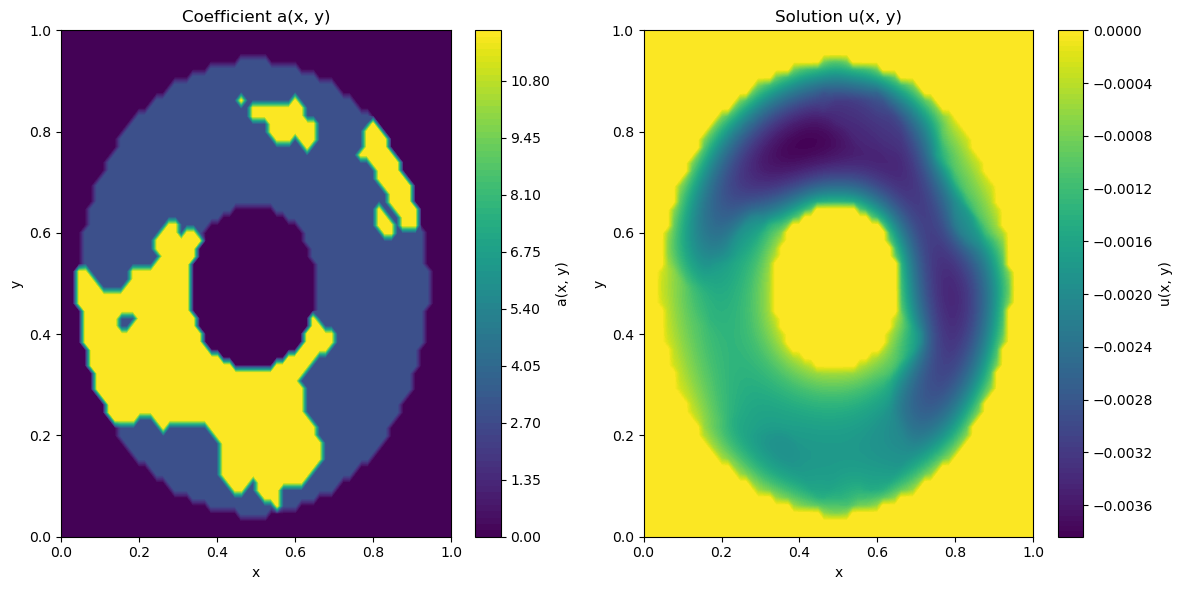

In [34]:
# plot an input_output pair

a, u = input_output_pairs[15]

# Visualize a(x, y) and u(x, y) side by side
X, Y = np.meshgrid(x, y, indexing="ij")
plt.figure(figsize=(12, 6))

# Plot a(x, y)
plt.subplot(1, 2, 1)
plt.contourf(X, Y, a, levels=100, cmap="viridis")
plt.colorbar(label="a(x, y)")
plt.title("Coefficient a(x, y)")
plt.xlabel("x")
plt.ylabel("y")

# Plot u(x, y)
plt.subplot(1, 2, 2)
plt.contourf(X, Y, u, levels=100, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.title("Solution u(x, y)")
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()
plt.show()

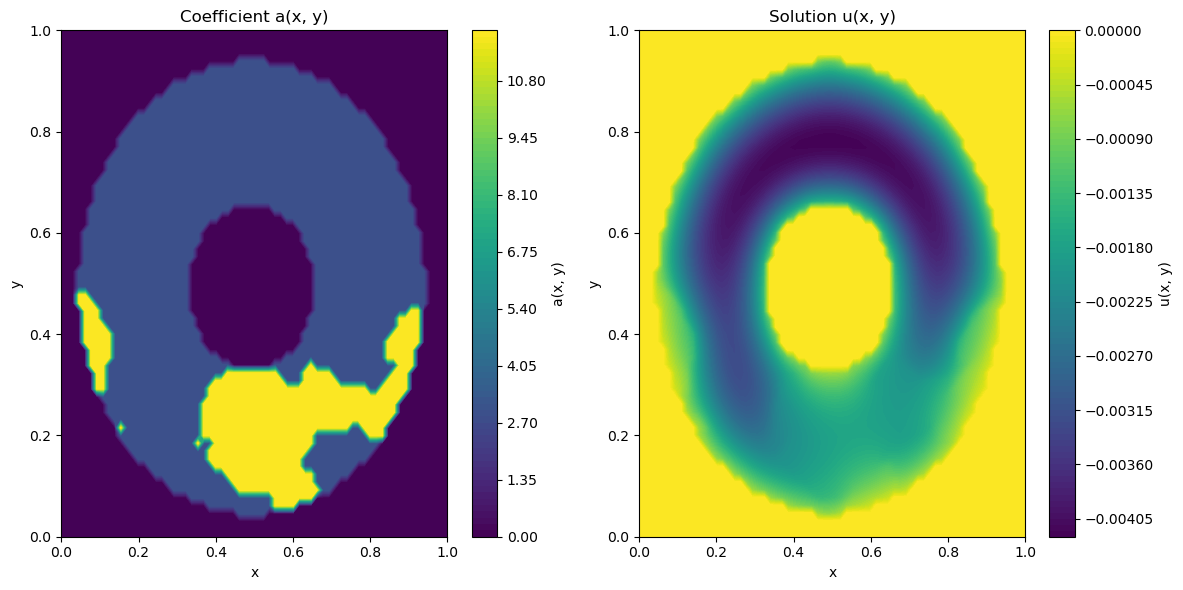

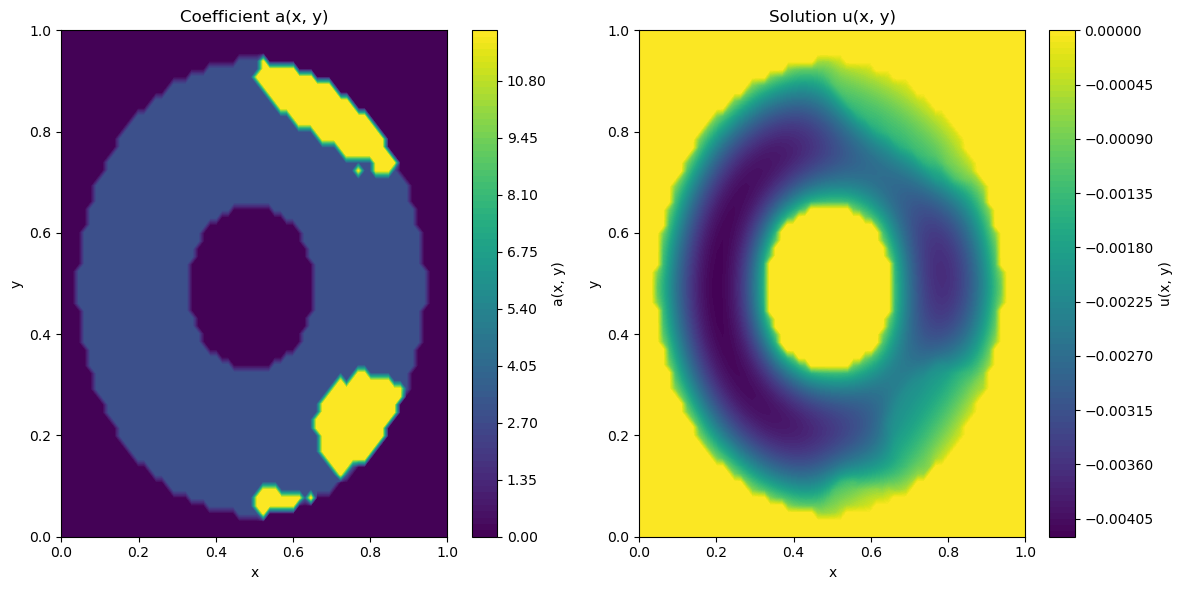

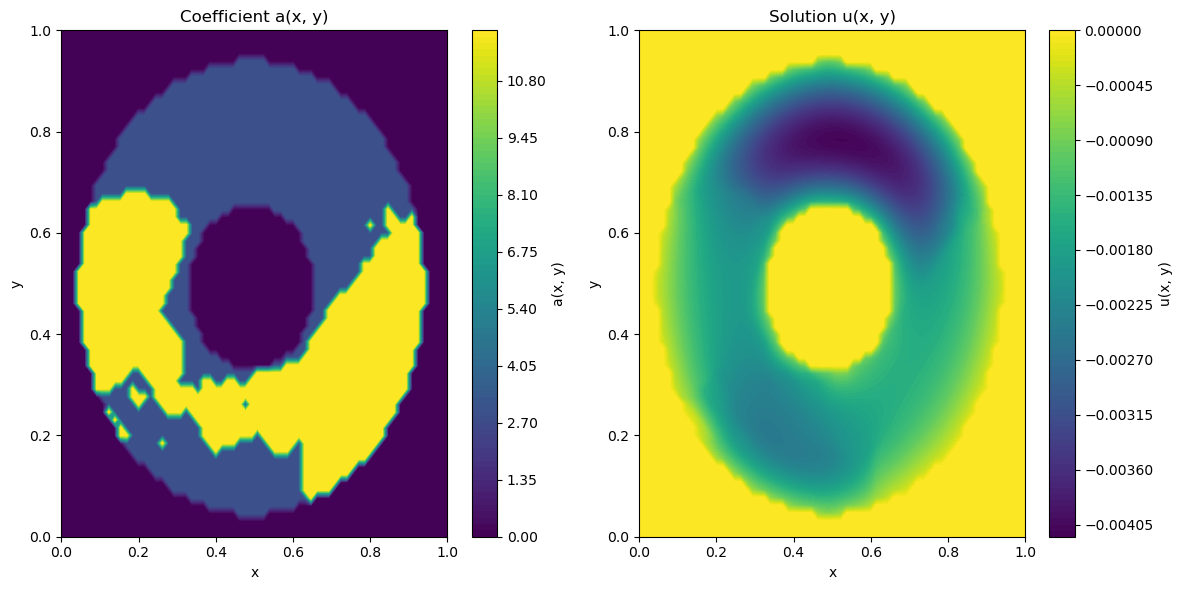

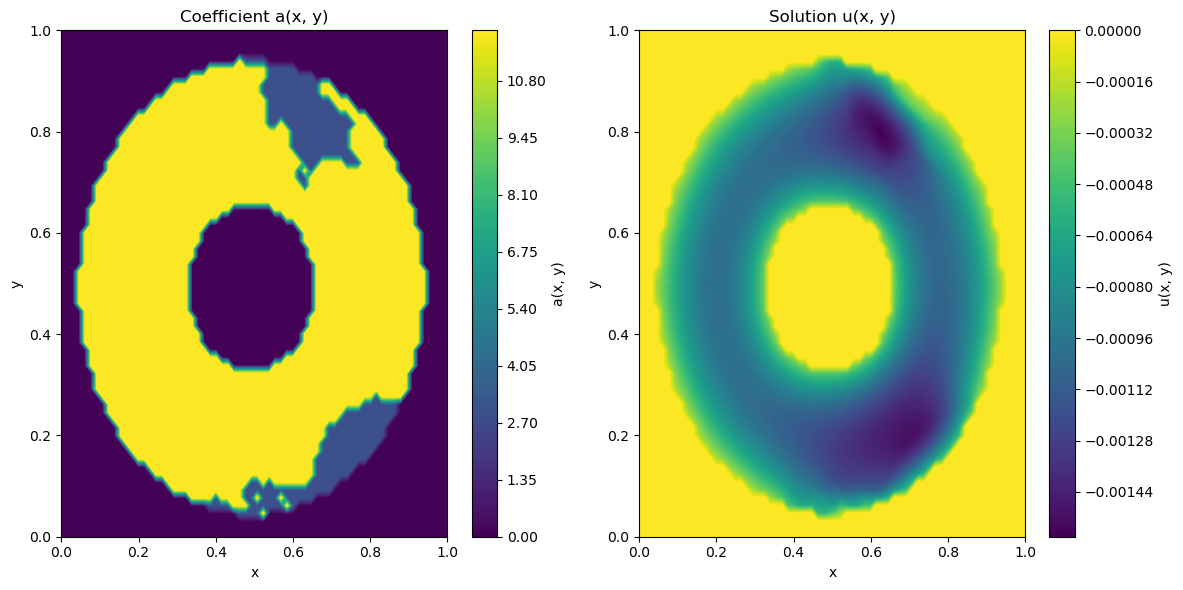

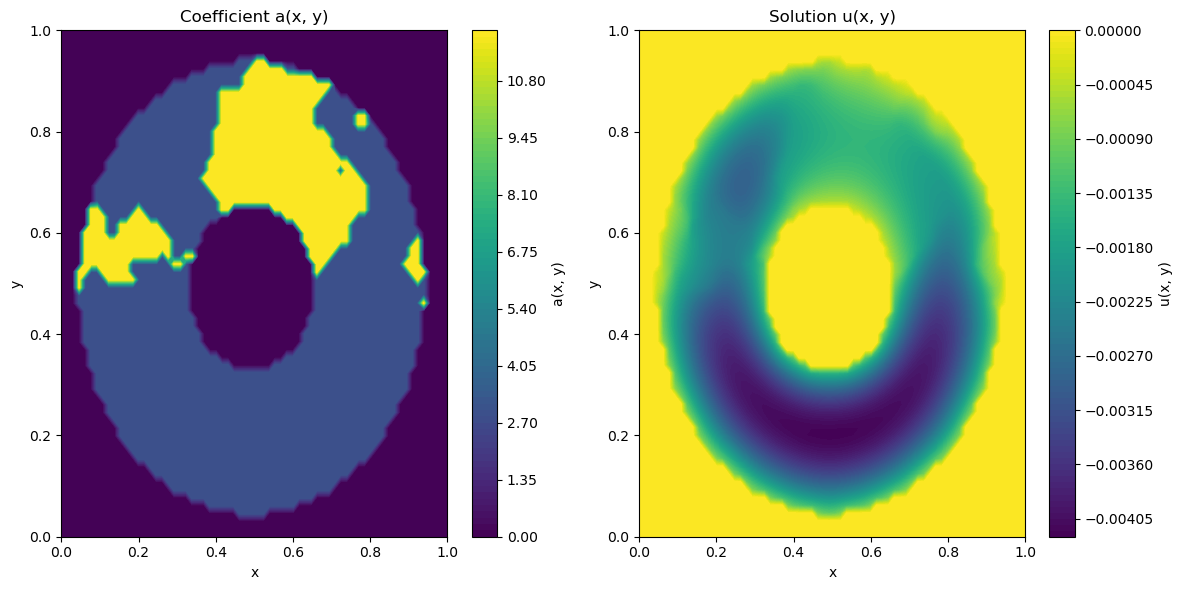

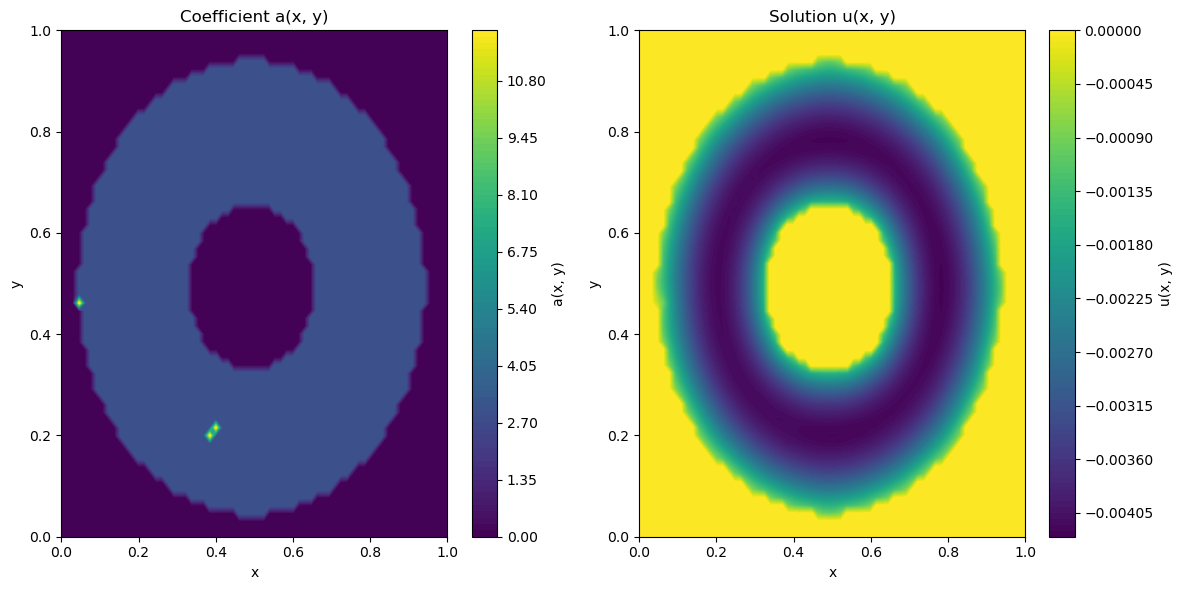

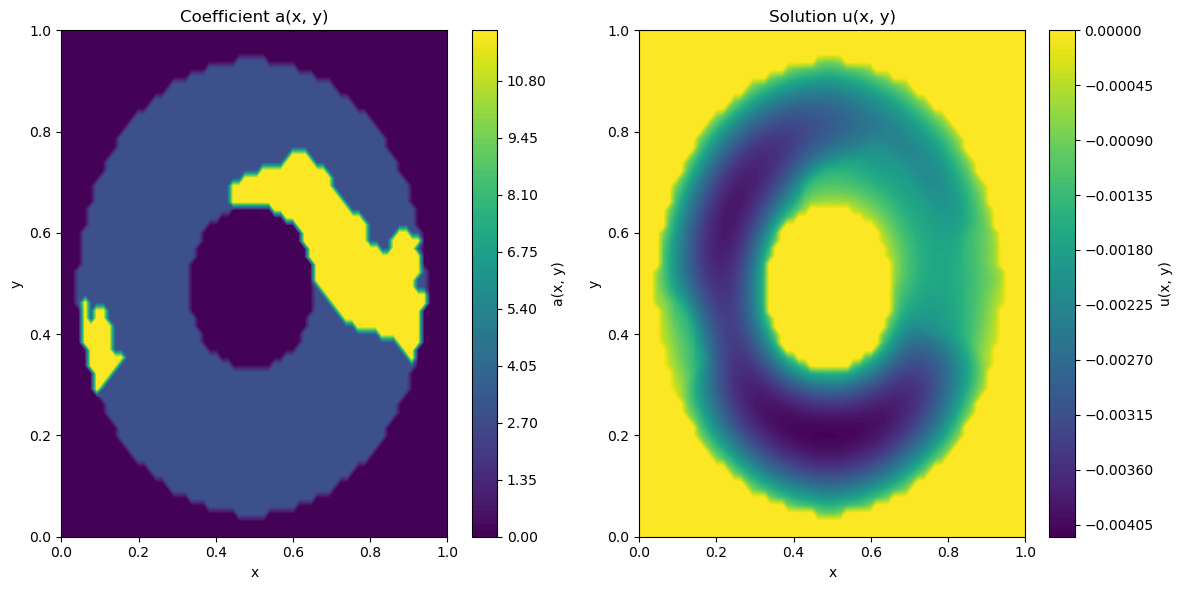

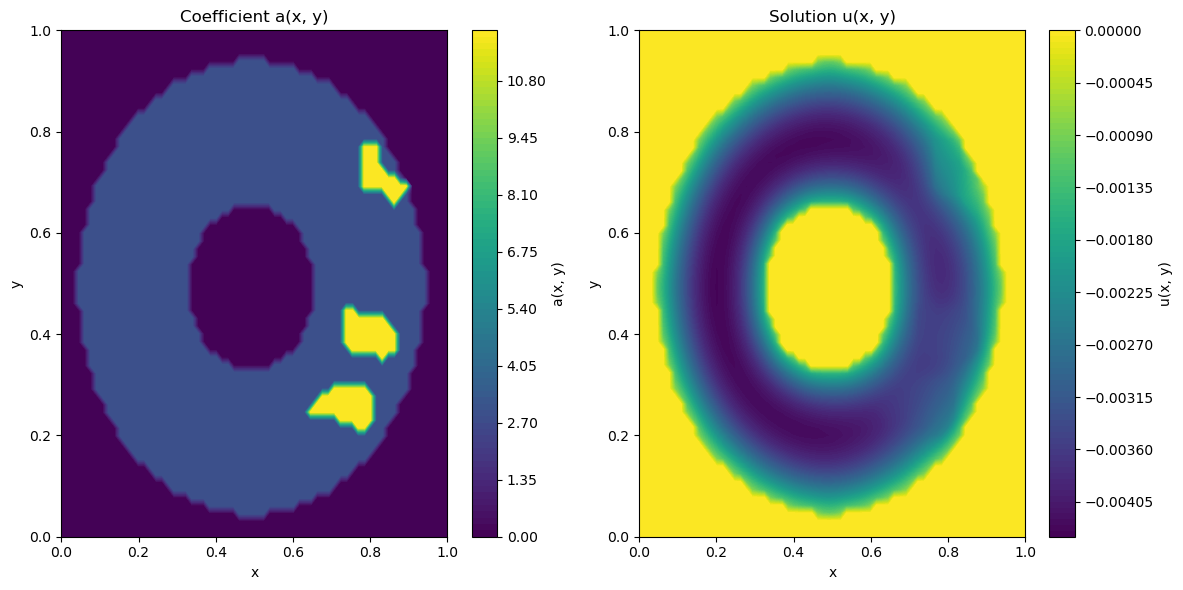

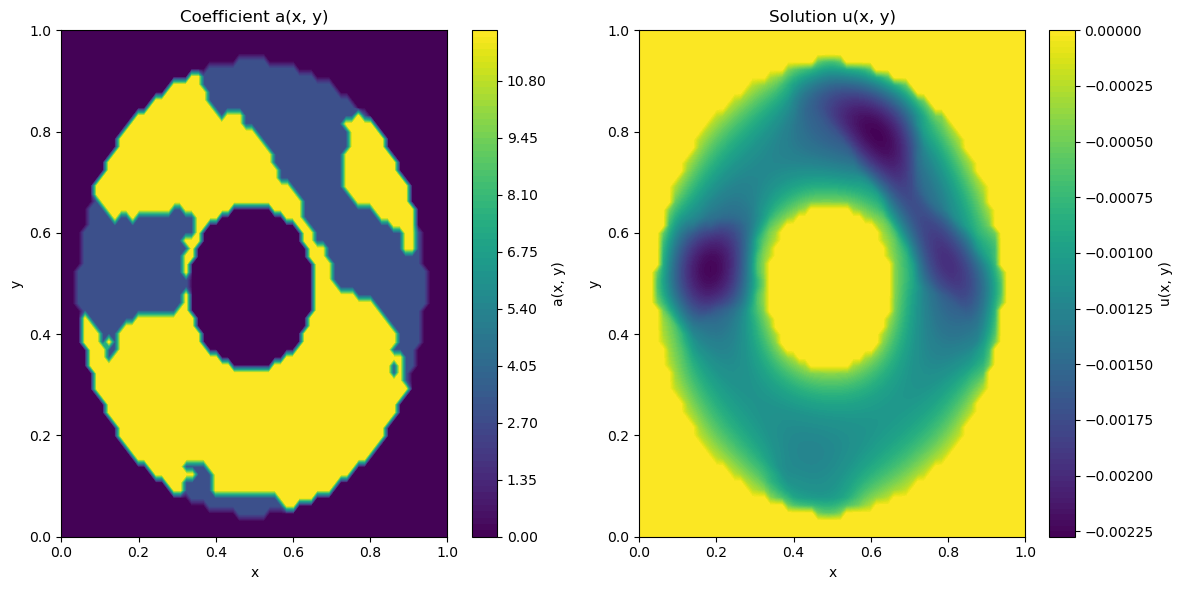

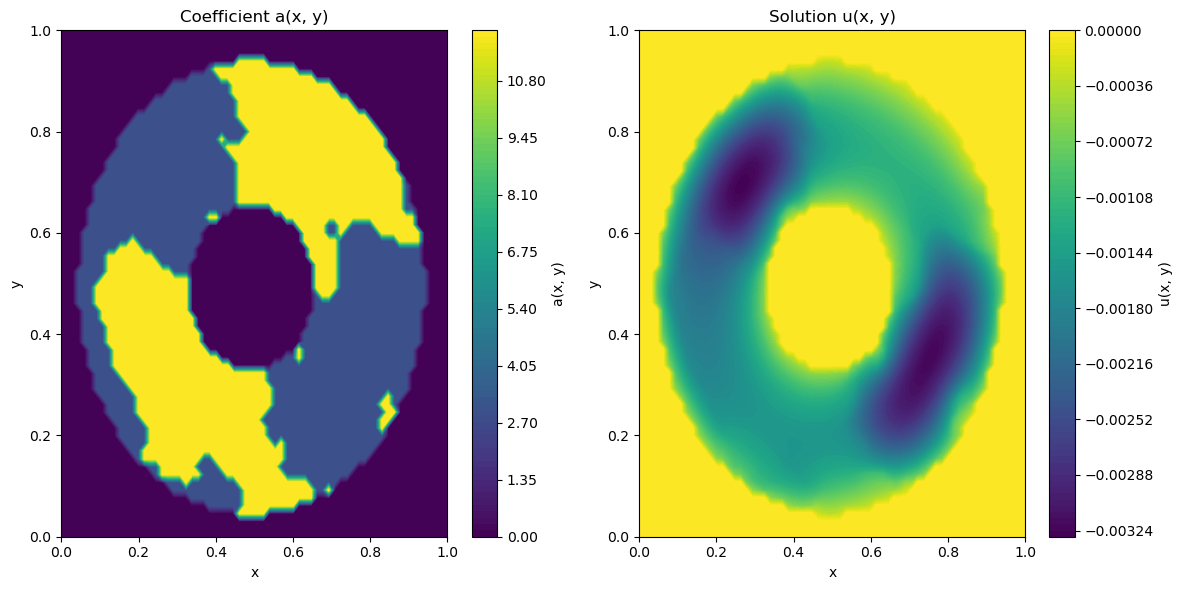

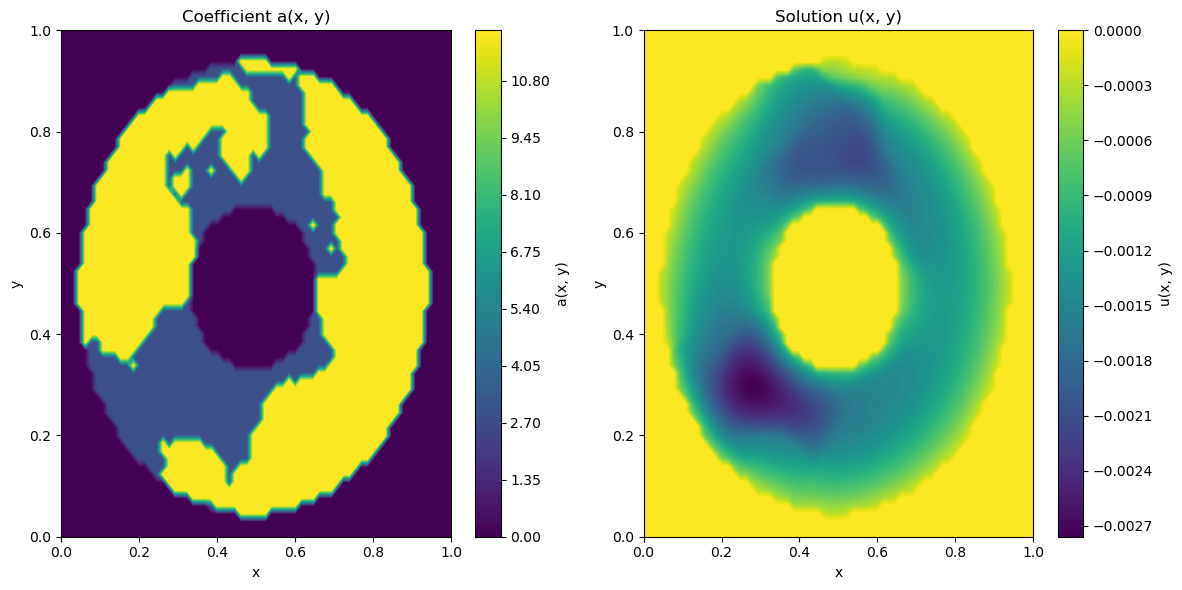

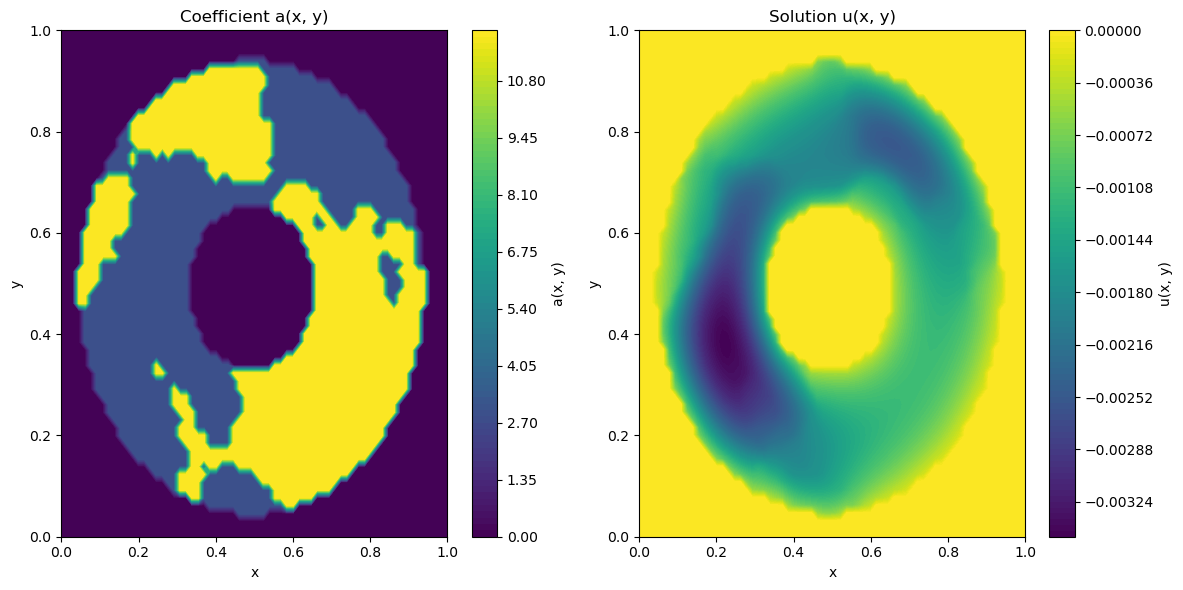

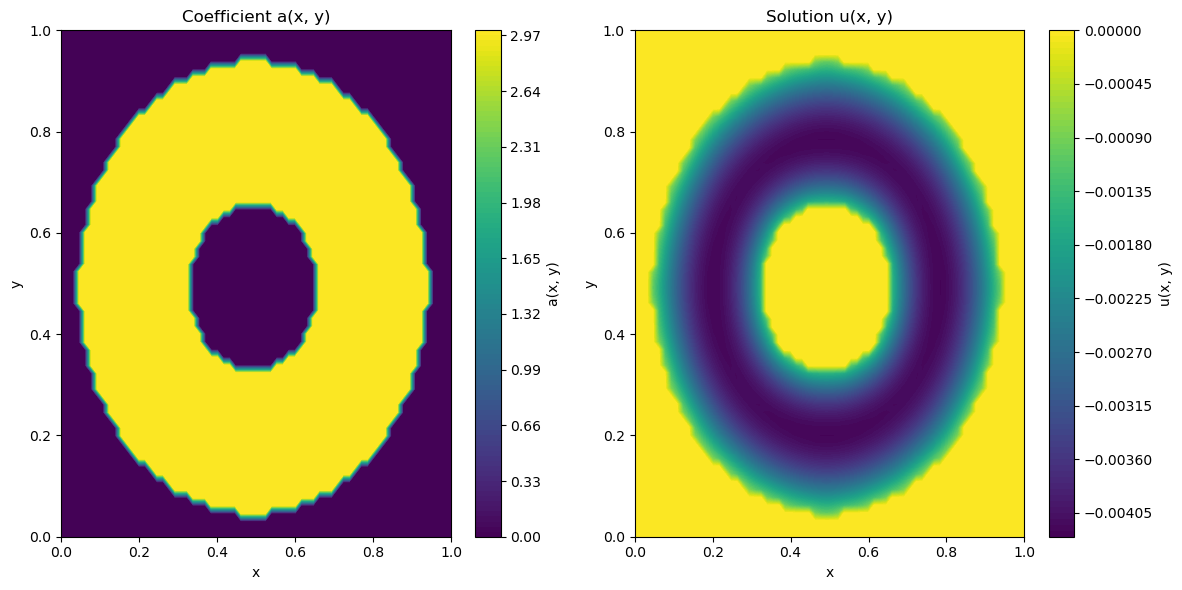

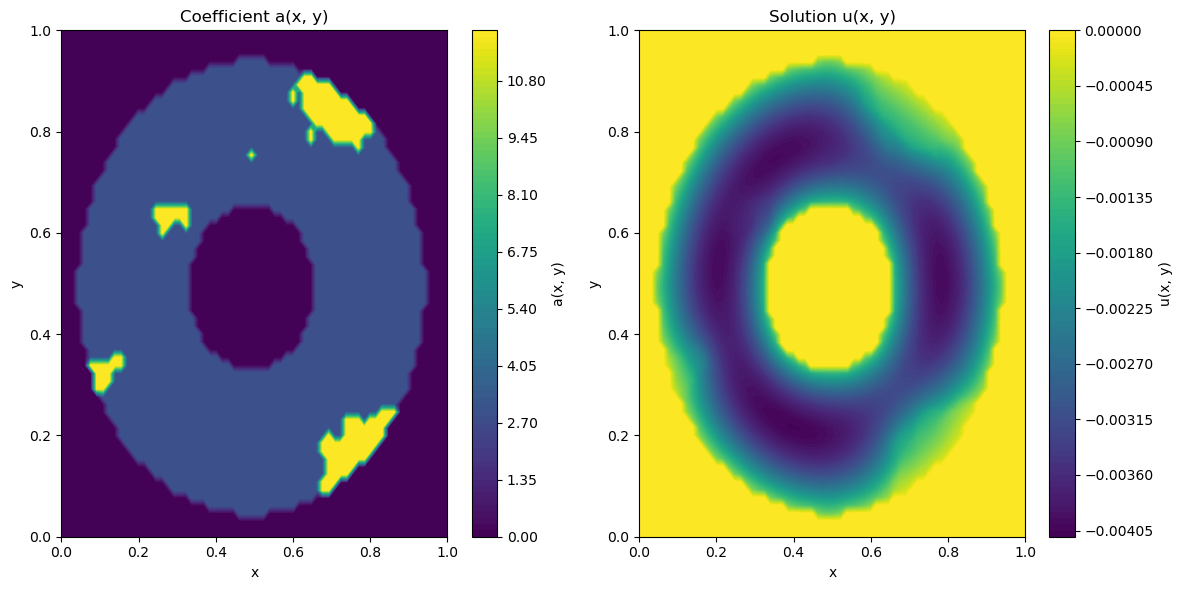

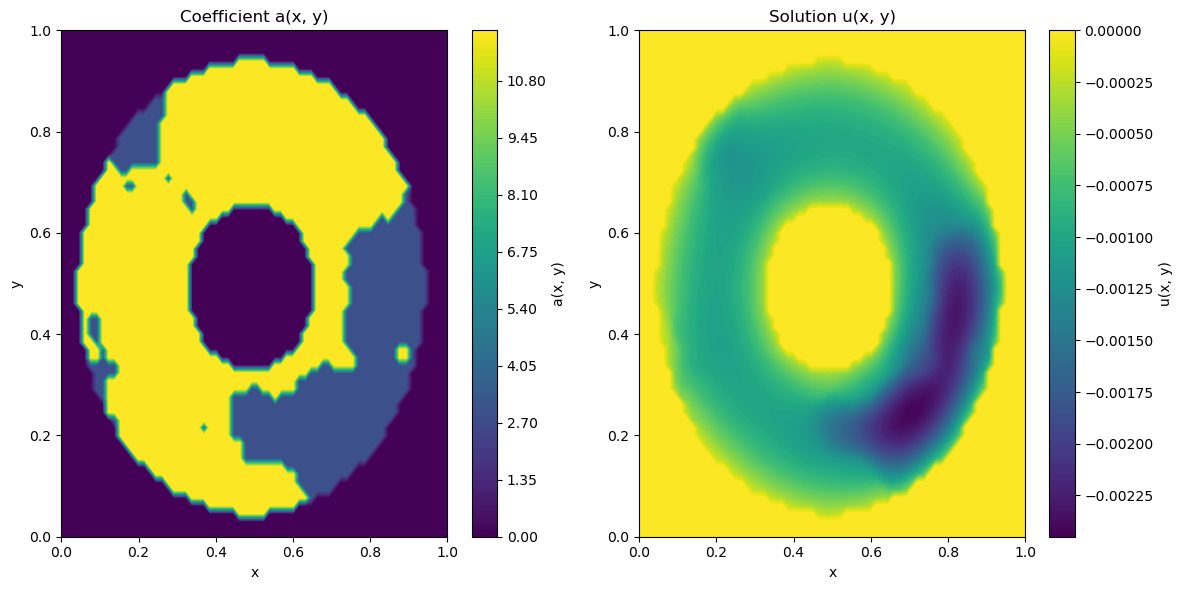

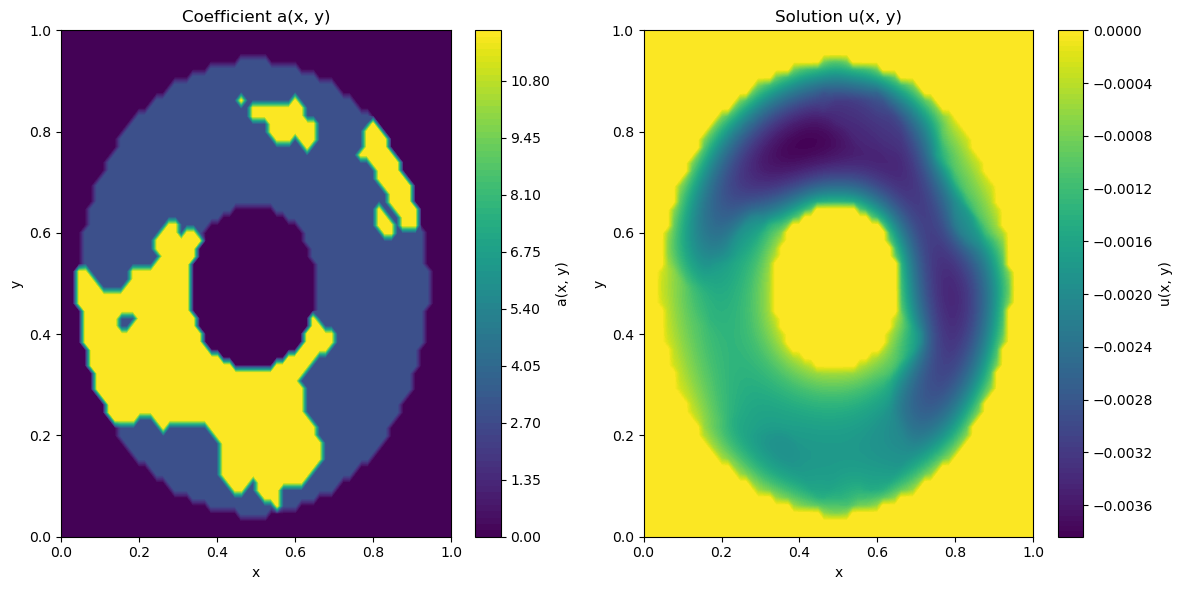

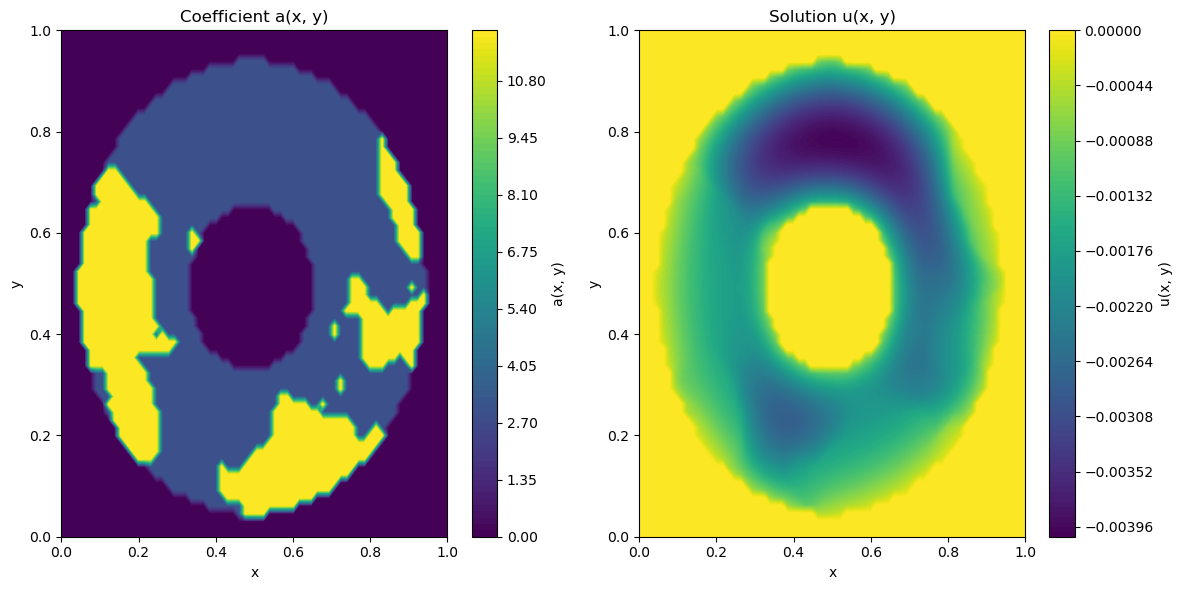

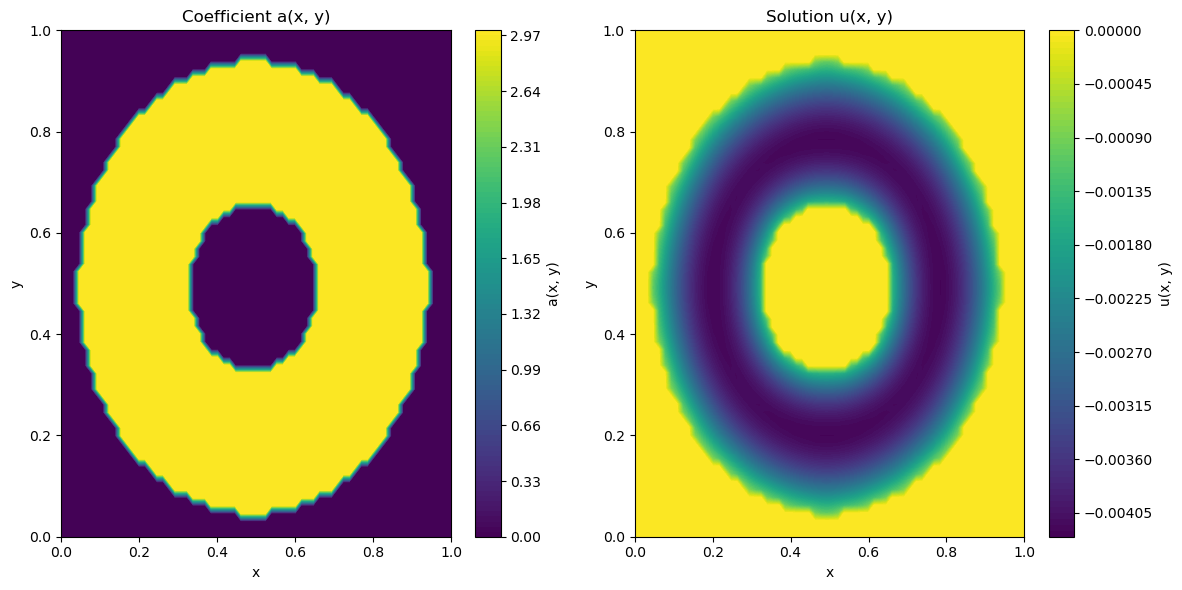

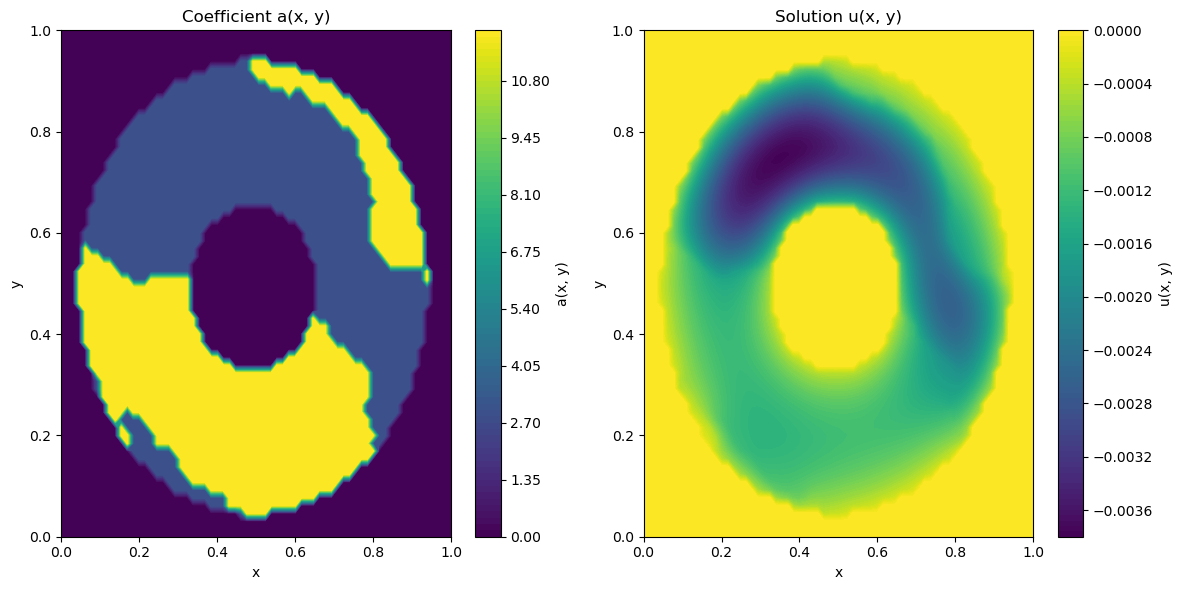

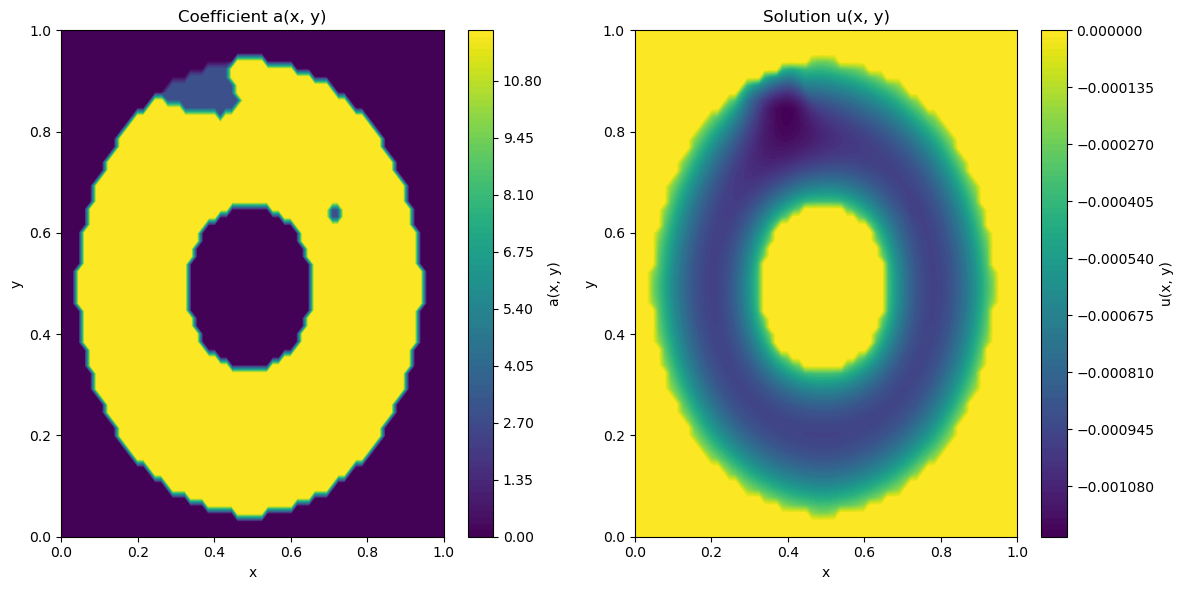

In [35]:
# plot an input_output pair

for i in range(20):

    a, u = input_output_pairs[i]

    # Visualize a(x, y) and u(x, y) side by side
    X, Y = np.meshgrid(x, y, indexing="ij")
    plt.figure(figsize=(12, 6))

    # Plot a(x, y)
    plt.subplot(1, 2, 1)
    plt.contourf(X, Y, a, levels=100, cmap="viridis")
    plt.colorbar(label="a(x, y)")
    plt.title("Coefficient a(x, y)")
    plt.xlabel("x")
    plt.ylabel("y")

    # Plot u(x, y)
    plt.subplot(1, 2, 2)
    plt.contourf(X, Y, u, levels=100, cmap="viridis")
    plt.colorbar(label="u(x, y)")
    plt.title("Solution u(x, y)")
    plt.xlabel("x")
    plt.ylabel("y")

    plt.tight_layout()
    plt.show()

In [45]:
# make an array that stores the xy coordinates
coordinates_grid = np.zeros(shape=(a.shape[0], a.shape[1], 2))

In [49]:
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        coordinates_grid[i, j] = x[i], y[j]

In [54]:
filename = 'donut_data_coord_grid.pkl'

with open(filename, 'wb') as file:
        pickle.dump(coordinates_grid, file)
        print(f"grid saved successfully to {filename}.")

grid saved successfully to donut_data_coord_grid.pkl.


0